In [2]:
import random
import warnings
from copy import deepcopy

import torch
from cifar_utils import get_dataloader, plot_dataset, plot_history, torch_inference, train
from models import Fp32VGG11

warnings.filterwarnings("ignore")

In [3]:
dataset_name = "CIFAR_10"

device = "cuda" if torch.cuda.is_available() else "cpu"

param_c10 = {
    "output_size": 10,
    "batch_size": 128,
    "training": "fp32",
    "dataset_name": "CIFAR_10",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_10",
    "seed": 727,
}
param_c100 = {
    "output_size": 100,
    "batch_size": 128,
    "training": "fp32",
    "dataset_name": "CIFAR_100",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "./checkpoints/CIFAR_100",
    "seed": 727,
}

# In this tutorial, we present the results of CIFAR-100.
if dataset_name == "CIFAR_100":
    param = param_c100
else:
    # If you want to use it for CIFAR-10, set `dataset_name` to "CIFAR_100"
    param = param_c10

print(f"Device Type: {device}")

Device Type: cpu


## Dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


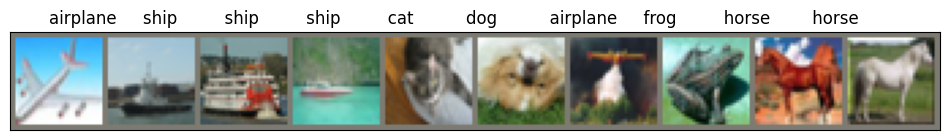

In [5]:
# Load CIFAR-100 or CIFAR-10 data-set according to `dataset_name`.
train_loader, test_loader = get_dataloader(param=param)

# Let’s visualize `n` images from CIFAR data-set.
plot_dataset(test_loader, param)

## Load VGG-11 pre-trained weights

In [7]:
torch.manual_seed(param["seed"])
random.seed(param["seed"])

fp32_vgg = Fp32VGG11(param["output_size"]).to(device)

pretrained_weights = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "vgg11",
    pretrained=True,
).state_dict()

fp32_vgg.load_state_dict(deepcopy(pretrained_weights), strict=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/masatotsutsumi/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /Users/masatotsutsumi/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

_IncompatibleKeys(missing_keys=['final_layer.weight', 'final_layer.bias'], unexpected_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

## Training

#### Fine-tuning the final layer

In [8]:
for p in list(fp32_vgg.parameters()):
    p.requires_grad = False

fp32_vgg.final_layer.weight.requires_grad = True
fp32_vgg.final_layer.bias.requires_grad = True

In [10]:
if dataset_name == "CIFAR_100":
    param["lr"] = 0.06
    param["epochs"] = 10
    param["gamma"] = 0.01
    param["milestones"] = [1]

elif dataset_name == "CIFAR_10":
    param["lr"] = 0.1
    param["epochs"] = 5
    param["gamma"] = 0.1
    param["milestones"] = [1, 3]

fp32_vgg = train(fp32_vgg, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 1.0684 VS Test loss = 1.0181 - Accuracy train: 0.6420 VS Accuracy test: 0.6947
Epoch  1: Train loss = 0.9503 VS Test loss = 0.8467 - Accuracy train: 0.6755 VS Accuracy test: 0.7276
Epoch  2: Train loss = 0.9263 VS Test loss = 0.8446 - Accuracy train: 0.6801 VS Accuracy test: 0.7256
Epoch  3: Train loss = 0.9092 VS Test loss = 0.8259 - Accuracy train: 0.6865 VS Accuracy test: 0.7301
Epoch  4: Train loss = 0.9100 VS Test loss = 0.8254 - Accuracy train: 0.6864 VS Accuracy test: 0.7298
100%|█| 5/5 [18:51<00:00, 


#### Fine-tuning all layers

In [12]:
for p in list(fp32_vgg.parameters()):
    p.requires_grad = True

if dataset_name == "CIFAR_100":
    param["lr"] = 0.0006
    param["epochs"] = 7
    param["gamma"] = 0.1
    param["milestones"] = [6]

elif dataset_name == "CIFAR_10":
    param["lr"] = 0.0006
    param["epochs"] = 5
    param["gamma"] = 0.1
    param["milestones"] = [4]

fp32_vgg = train(fp32_vgg, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 1.2066 VS Test loss = 0.7102 - Accuracy train: 0.5794 VS Accuracy test: 0.7582
Epoch  1: Train loss = 0.6168 VS Test loss = 0.5091 - Accuracy train: 0.7873 VS Accuracy test: 0.8247
Epoch  2: Train loss = 0.4817 VS Test loss = 0.4075 - Accuracy train: 0.8322 VS Accuracy test: 0.8604
Epoch  3: Train loss = 0.3939 VS Test loss = 0.3971 - Accuracy train: 0.8659 VS Accuracy test: 0.8667
Epoch  4: Train loss = 0.2267 VS Test loss = 0.3161 - Accuracy train: 0.9211 VS Accuracy test: 0.8997
100%|█| 5/5 [44:37<00:00, 


In [13]:
acc = torch_inference(fp32_vgg, data=test_loader, device=device)

In [14]:
print(f"with {dataset_name}: top-1 accuracy = {acc * 100:2.3f}%")

with CIFAR_10: top-1 accuracy = 89.994%


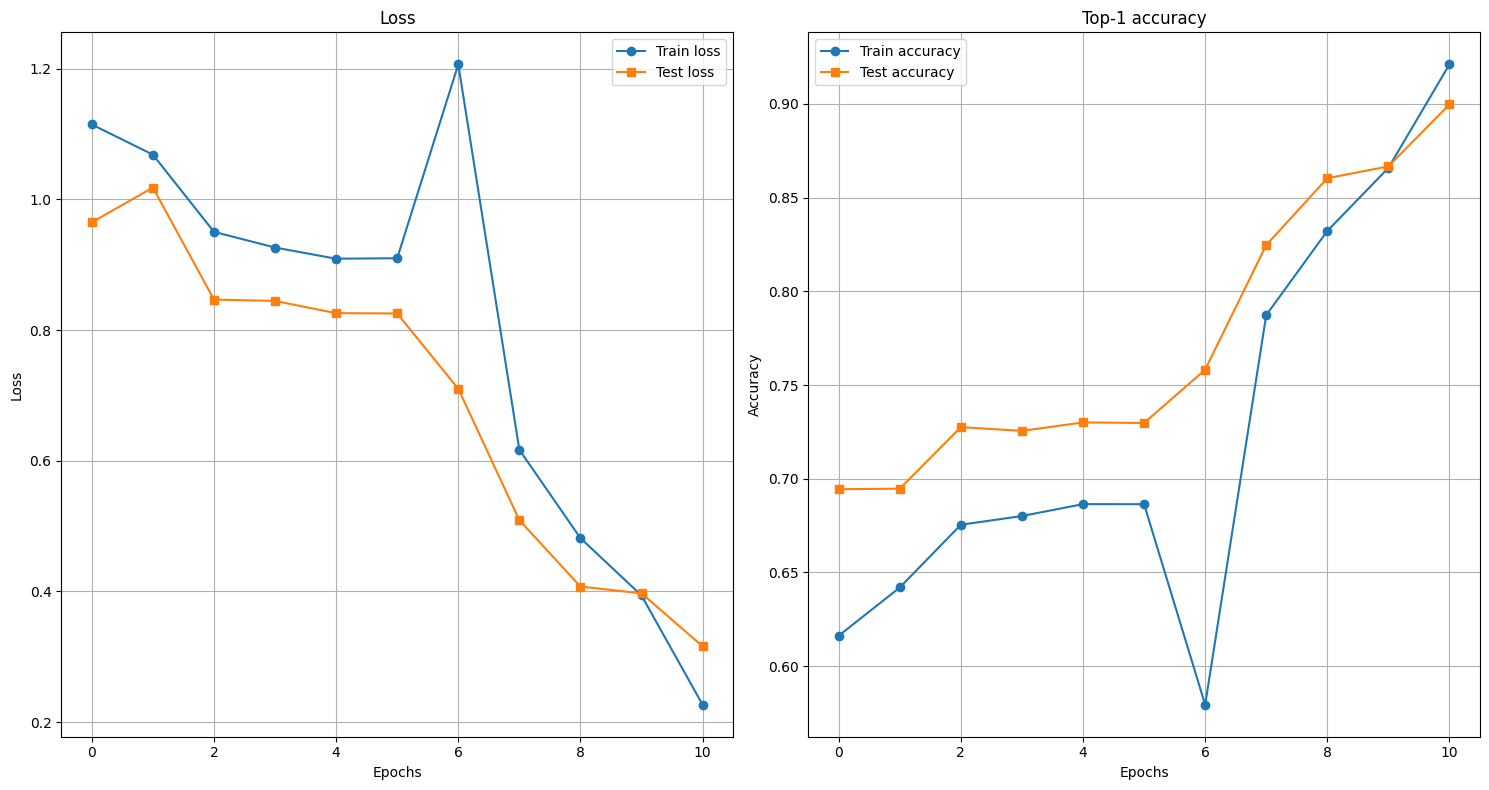

In [15]:
plot_history(param)